In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import re
from Constants import *
import simplejson
from Preprocessing import *
from Models import *
from scipy.spatial.distance import cdist

In [4]:
# def load_trained_models():
#     files = [Const.model_dir + f for f in Const.tuned_transition_models]
#     decision_file = Const.model_dir + Const.tuned_decision_model
#     [model1,model2,model3] = [torch.load(file) for file in files]
#     decision_model = torch.load(decision_file)
#     return decision_model, model1,model2,model3
# decision_model, transition_model1, transition_model2, outcome_model =load_trained_models()
# decision_model

In [5]:
def load_models():
    files = [
        '../resources/decision_model.pt',
        '../resources/transition1_model.pt',
        '../resources/transition2_model.pt',
        '../resources/outcome_model.pt',
    ]
    decision_model,transition_model1,transition_model2, outcome_model = [torch.load(file) for file in files]
    return decision_model,transition_model1,transition_model2,outcome_model
decision_model,transition_model1,transition_model2, outcome_model = load_models()
transition_model1

TransitionEnsemble(
  (base_models): ModuleList(
    (0-1): 2 x OutcomeSimulator(
      (input_dropout): Dropout(p=0.1, inplace=False)
      (layers): ModuleList(
        (0): Linear(in_features=57, out_features=300, bias=True)
        (1): ReLU()
        (2): Linear(in_features=300, out_features=300, bias=True)
        (3): ReLU()
      )
      (batchnorm): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.9, inplace=False)
      (relu): Softplus(beta=1, threshold=20)
      (sigmoid): Sigmoid()
      (softmax): LogSoftmax(dim=1)
      (disease_layer): Linear(in_features=300, out_features=3, bias=True)
      (nodal_disease_layer): Linear(in_features=300, out_features=3, bias=True)
      (dlt_layers): ModuleList(
        (0-7): 8 x Linear(in_features=300, out_features=1, bias=True)
      )
      (treatment_layer): Linear(in_features=300, out_features=7, bias=True)
    )
    (2-3): 2 x OutcomeSimulator(
      (input_dropout): Dr

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
decision_model.set_device(device)
transition_model1.set_device(device)
transition_model2.set_device(device)
outcome_model.set_device(device)

In [7]:
data = DTDataset()
newdf = data.processed_df.copy()
for c in newdf.columns:
    if newdf[c].dtype == np.float64:
        newdf[c] = newdf[c].astype(np.float32).apply(lambda x: np.round(x,2))
data.processed_df = newdf
data.processed_df

/data/DigitalTwinVis/python/Preprocessing.py:249: DtypeWarning: Columns (55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file)


,hpv,age,packs_per_year,smoking_status,gender,Aspiration rate Pre-therapy,total_dose,dose_fraction,bilateral,White/Caucasian,...,4_ipsi,4_contra,5A_ipsi,5A_contra,5B_ipsi,5B_contra,6_ipsi,6_contra,RPLN_ipsi,RPLN_contra
id,,,,,,,,,,,,,,,,,,,,,
3,1,55.97,0.0,0.0,1,0,66.00,2.20,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,20.95,38.0,1.0,1,0,72.00,1.80,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,69.93,35.0,1.0,0,1,70.00,2.12,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,72.32,0.0,1.0,1,0,70.00,2.12,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,59.73,0.0,0.0,1,0,66.00,2.20,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10201,1,49.57,30.0,1.0,1,0,70.00,2.12,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10202,0,48.71,30.0,1.0,1,0,72.00,1.71,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10203,1,77.12,0.0,0.0,1,0,70.00,2.33,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
test_patient_id = 7
test_patient = data.processed_df.loc[test_patient_id].to_dict()
test_patient

{'hpv': 1,
 'age': 72.32,
 'packs_per_year': 0.0,
 'smoking_status': 1.0,
 'gender': 1,
 'Aspiration rate Pre-therapy': 0,
 'total_dose': 70.0,
 'dose_fraction': 2.12,
 'bilateral': False,
 'White/Caucasian': False,
 'Hispanic/Latino': False,
 'African American/Black': False,
 'cc_none': 1,
 'cc_platinum': 0,
 'cc_cetuximab': 0,
 'cc_others': 0,
 'no_dose_adjustment': 1,
 'dose_modified': 0,
 'dose_delayed': 0,
 'dose_cancelled': 0,
 'dose_delayed_&_modified': 0,
 'regiment_modification': 0,
 'unknown': 0,
 'T-category_1': 1,
 'T-category_2': 0,
 'T-category_3': 0,
 'T-category_4': 0,
 'N-category_0': 0,
 'N-category_1': 0,
 'N-category_2': 1,
 'N-category_3': 0,
 'AJCC_1': 0,
 'AJCC_2': 1,
 'AJCC_3': 0,
 'AJCC_4': 0,
 'Pathological Grade_0': 1,
 'Pathological Grade_1': 0,
 'Pathological Grade_2': 0,
 'Pathological Grade_3': 0,
 'Pathological Grade_4': 0,
 'subsite_BOT': 0,
 'subsite_GPS': 0,
 'subsite_NOS': 1,
 'subsite_Soft palate': 0,
 'subsite_Tonsil': 0,
 'treatment_CC': 0,
 'trea

In [9]:
def df_to_torch(df,ttype  = torch.FloatTensor):
    values = df.values.astype(float)
    values = torch.from_numpy(values)
    return values.type(ttype)

def get_decision_input(dataset,state=0,ids=None):
    baseline = dataset.get_state('baseline')
    dlt1 = dataset.get_state('dlt1')
    dlt2 = dataset.get_state('dlt2')
    pd1 = dataset.get_state('pd_states1')
    pd2 = dataset.get_state('pd_states2')
    nd1 = dataset.get_state('nd_states1')
    nd2 = dataset.get_state('nd_states2')
    modifications = dataset.get_state('modifications')
    ccs = dataset.get_state('ccs')
    if state < 2:
        pd = pd1.copy()
        nd = nd1.copy()
        dlt2.values[:,:] = np.zeros(dlt2.shape)
        ccs.values[:,:] = np.zeros(ccs.shape)
        if state < 1:
            dlt1.values[:,:] = np.zeros(dlt1.shape)
            modifications.values[:,:] = np.zeros(modifications.shape)
            pd.values[:,:] = np.zeros(pd.shape)
            nd.values[:,:] = np.zeros(nd.shape)
    else:
        pd = pd2.copy()
        nd = nd2.copy()
        
    output = [baseline, dlt1, dlt2, pd, nd,ccs,modifications]
    if ids is not None:
        output = [o.loc[ids] for o in output]
    return output
get_decision_input(data,ids=[test_patient_id])[0]

,1A_contra,1A_ipsi,1B_contra,1B_ipsi,2A_contra,2A_ipsi,2B_contra,2B_ipsi,3_contra,3_ipsi,...,gender,hpv,packs_per_year,smoking_status,subsite_BOT,subsite_GPS,subsite_NOS,subsite_Soft palate,subsite_Tonsil,total_dose
id,,,,,,,,,,,,,,,,,,,,,
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0.0,1.0,0,0,1,0,0,70.0


In [10]:
def get_inputkey_order(dataset,state=0):
    return [list(f.columns) for f in get_decision_input(dataset,state=state)]

get_inputkey_order(data,1)

[['1A_contra',
  '1A_ipsi',
  '1B_contra',
  '1B_ipsi',
  '2A_contra',
  '2A_ipsi',
  '2B_contra',
  '2B_ipsi',
  '3_contra',
  '3_ipsi',
  '4_contra',
  '4_ipsi',
  '5A_contra',
  '5A_ipsi',
  '5B_contra',
  '5B_ipsi',
  '6_contra',
  '6_ipsi',
  'AJCC_1',
  'AJCC_2',
  'AJCC_3',
  'AJCC_4',
  'African American/Black',
  'Aspiration rate Pre-therapy',
  'DLT (Y/N)',
  'DLT_Grade',
  'Hispanic/Latino',
  'N-category_0',
  'N-category_1',
  'N-category_2',
  'N-category_3',
  'Pathological Grade_0',
  'Pathological Grade_1',
  'Pathological Grade_2',
  'Pathological Grade_3',
  'Pathological Grade_4',
  'RPLN_contra',
  'RPLN_ipsi',
  'T-category_1',
  'T-category_2',
  'T-category_3',
  'T-category_4',
  'White/Caucasian',
  'age',
  'bilateral',
  'dose_fraction',
  'gender',
  'hpv',
  'packs_per_year',
  'smoking_status',
  'subsite_BOT',
  'subsite_GPS',
  'subsite_NOS',
  'subsite_Soft palate',
  'subsite_Tonsil',
  'total_dose'],
 ['DLT_Nephrological',
  'DLT_Hematological',
  'D

In [11]:
test = get_inputkey_order(data)
[test[0].index(t) for t in test[0] if '_contra' in t], [test[0].index(t) for t in test[0] if '_ipsi' in t]

([0, 2, 4, 6, 8, 10, 12, 14, 16, 36], [1, 3, 5, 7, 9, 11, 13, 15, 17, 37])

In [13]:
def get_embeddings(dataset,dm,states=[0,1,2],use_saved_memory=True,decimals=2):
    embeddings = []
    inputs = []
    decisions_optimal = [[] for i in states]
    decisions_imitation = [[] for i in states]
    for i,state in enumerate(states):
        x = get_decision_input(dataset,state=state)
        x = torch.cat([df_to_torch(f) for f in x],axis=1)
        embedding = dm.get_embedding(x,position = state,use_saved_memory=use_saved_memory)
        inputs.append(x.detach().numpy())
        decision = dm(x,position=state).cpu().detach().numpy()
        decisions_optimal[i].append(decision[:,state])
        decisions_imitation[i].append(decision[:,state+3])
        embedding = embedding.cpu().detach().numpy()
        if decimals is not None:
            embedding = np.round(embedding,decimals)
        embeddings.append(embedding)
    return embeddings,np.array(decisions_optimal).reshape(len(states),-1).T, np.array(decisions_imitation).reshape(len(states),-1).T, inputs
embeddings, decisions_optimal, decisions_imitation, testinputs = get_embeddings(data,decision_model)
[e.shape for e in embeddings]

[(536, 50), (536, 50), (536, 50)]

In [36]:
next(transition_model1.parameters())

Parameter containing:
tensor([[ 0.0140, -0.0578,  0.1246,  ...,  0.0248,  0.0838,  0.0484],
        [ 0.0815,  0.0955,  0.0431,  ..., -0.0003, -0.1090,  0.0191],
        [-0.0589,  0.0514, -0.0826,  ..., -0.0235,  0.0021, -0.0316],
        ...,
        [ 0.0140,  0.0155,  0.1288,  ..., -0.0689, -0.1340,  0.1305],
        [-0.0237,  0.1009,  0.0360,  ..., -0.1284, -0.1223, -0.0078],
        [ 0.0265,  0.0236, -0.0570,  ...,  0.1332, -0.0386,  0.1328]],
       device='cuda:0', requires_grad=True)

In [14]:
def get_predictions(dataset,m1,m2,m3,states=[0,1,2],ids=None):
    outcomes = {}
    def add_outcomes(names, array,suffix=''):
        for i,name in enumerate(names):
            outcomes[name+suffix] = array[:,i]
    for model,state in zip([m1,m2,m3],states):
        x = dataset.get_input_state(step=state+1,ids=ids)
        x = df_to_torch(x).to(model.get_device())
        yout = model(x)
        y = yout['predictions']
        y_lower = yout['5%']
        y_upper = yout['95%']
        if state < 2:
            y = [yy.cpu().detach().numpy() for yy in y]
            y_lower = [yy.cpu().detach().numpy() for yy in y_lower]
            y_upper = [yy.cpu().detach().numpy() for yy in y_upper]
        else:
            y = y.cpu().detach().numpy()
            y_lower = y_lower.cpu().detach().numpy()
            y_upper = y_upper.cpu().detach().numpy()
        if state == 0:
            for suffixes, values in zip(['','_5%','_95%'],[y,y_lower,y_upper]):
                [pds, nd, mod, dlts] = values
                add_outcomes(Const.primary_disease_states,pds,suffixes)
                add_outcomes(Const.nodal_disease_states,nd,suffixes)
                add_outcomes(Const.modifications,mod,suffixes)
                add_outcomes(Const.dlt1,dlts,suffixes)
        elif state == 1:
            for suffixes, values in zip(['','_5%','_95%'],[y,y_lower,y_upper]):
                [pd2, nd2, cc, dlts2] = values
                add_outcomes(Const.primary_disease_states2,pd2,suffixes)
                add_outcomes(Const.nodal_disease_states2,nd2,suffixes)
                add_outcomes(Const.dlt2,dlts2,suffixes)
        else:
            for suffixes, values in zip(['','_5%','_95%'],[y,y_lower,y_upper]):
                add_outcomes(Const.outcomes,values,suffixes)
    if ids is None:
        ids = dataset.processed_df.index.values
    outcomes = pd.DataFrame(outcomes,ids)
    outcomes.index.name = 'id'
    return outcomes
prediction_df = get_predictions(data,transition_model1,transition_model2,outcome_model,ids=[3,5,7])
prediction_df[['FT','FT_5%','FT_95%']]

,FT,FT_5%,FT_95%
id,,,
3,0.128817,0.080893,0.362487
5,0.404082,0.163900,0.514166
7,0.063777,0.006287,0.218088


In [16]:
from sklearn.decomposition import PCA
def get_embedding_pcas(dataset,decision_model,embeddings=None,components=2):
    if embeddings is None:
        embeddings, _, _, _ = get_embeddings(dataset,decision_model,states=[0,1,2])
    pcas = [PCA(components,whiten=True).fit(e) for e in embeddings]
    return pcas

def get_embedding_df(dataset,dm,states=[0,1,2],pcas=None,**kwargs):
    embeddings, decisions_opt, decisions_im, embedding_inputs = get_embeddings(dataset,dm,
                                                                                      states=states,**kwargs)
    values = {'embeddings_state'+str(i): [np.array(ee) for ee in e] for i,e in zip(states,embeddings)}
    newdf = pd.DataFrame(values,index=dataset.processed_df.index.values)
    for ii in states:
        opt = decisions_opt[:,ii]
        im = decisions_im[:,ii]
        newdf['decision'+str(ii)+"_optimal"] = opt
        newdf['decision'+str(ii)+'_imitation'] = im
        newdf['inputs'+str(ii)] = [np.array(ee) for ee in embedding_inputs[ii]]
    
    if pcas is None:
        pcas = get_embedding_pcas(dataset,dm,embeddings=embeddings)
    reductions = [ipca.fit_transform(e) for ipca,e in zip(pcas,embeddings)]
    for state,r in enumerate(reductions):
        newdf['pca_state'+str(state)] = [np.array(rr) for rr in r]
    return newdf

embedding_df = get_embedding_df(data,decision_model)
embedding_df

,embeddings_state0,embeddings_state1,embeddings_state2,decision0_optimal,decision0_imitation,inputs0,decision1_optimal,decision1_imitation,inputs1,decision2_optimal,decision2_imitation,inputs2,pca_state0,pca_state1,pca_state2
3,"[0.0, 0.0, 0.0, 0.0, 1.81, 0.45, 0.27, 0.27, 2...","[0.0, 0.0, 0.0, 0.0, 1.78, 0.32, 0.24, 0.43, 2...","[0.0, 0.0, 0.0, 0.0, 1.67, 0.67, 0.12, 0.41, 2...",0.404411,0.857436,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...",0.551764,0.086573,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...",0.451284,0.061218,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...","[-0.91638935, 0.87547666]","[-0.7414349, 0.21748467]","[-0.724778, 1.3703718]"
5,"[0.29, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.58...","[0.0, 0.0, 0.0, 0.0, 0.18, 0.0, 0.0, 0.0, 1.87...","[0.0, 0.0, 0.0, 0.0, 0.24, 0.0, 0.0, 0.0, 1.62...",0.403303,0.724195,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",0.642500,0.423488,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",0.280270,0.325722,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","[1.553479, 1.4561901]","[1.4569191, 1.3550688]","[1.3935919, 0.74778825]"
6,"[0.0, 0.9, 0.44, 0.0, 0.33, 0.0, 0.0, 0.0, 0.1...","[0.0, 1.1, 0.53, 0.0, 0.34, 0.0, 0.0, 0.0, 0.0...","[0.0, 0.88, 0.58, 0.0, 0.24, 0.0, 0.0, 0.0, 0....",0.221700,0.541761,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.707133,0.536926,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.360935,0.739171,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[2.1293972, -0.13099144]","[2.28733, 0.94004595]","[2.3375874, 0.34899667]"
7,"[0.0, 0.0, 0.66, 0.0, 1.03, 0.63, 0.0, 0.0, 1....","[0.0, 0.0, 0.68, 0.0, 1.17, 0.58, 0.0, 0.0, 1....","[0.0, 0.0, 0.49, 0.0, 1.12, 0.62, 0.0, 0.0, 1....",0.478565,0.832102,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.494602,0.117294,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.390142,0.192733,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.04587466, 0.30180287]","[-0.0072225733, 1.4680485]","[0.16456433, 1.3345414]"
8,"[0.0, 0.0, 0.03, 0.0, 1.79, 0.43, 0.78, 0.0, 2...","[0.0, 0.0, 0.02, 0.0, 1.84, 0.35, 0.75, 0.0, 2...","[0.0, 0.0, 0.0, 0.0, 1.73, 0.39, 0.74, 0.0, 2....",0.334578,0.880160,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",0.457247,0.054677,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",0.573210,0.058421,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","[-1.1317844, 0.46806997]","[-1.0799164, -0.35291988]","[-1.1101974, -0.34079343]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10201,"[0.0, 0.0, 0.0, 0.0, 0.89, 1.3, 0.87, 0.0, 2.0...","[0.0, 0.0, 0.15, 0.0, 1.05, 1.25, 0.62, 0.0, 2...","[0.0, 0.0, 0.0, 0.0, 0.95, 1.56, 0.59, 0.0, 1....",0.297175,0.829670,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",0.461057,0.120034,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",0.423861,0.096465,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","[-0.22821945, 1.4296004]","[-0.43621224, 1.1600924]","[-0.43571296, 1.0510811]"
10202,"[0.0, 0.36, 0.0, 0.0, 0.13, 0.0, 0.0, 0.0, 0.8...","[0.0, 0.58, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 1.05...","[0.0, 0.57, 0.0, 0.0, 0.24, 0.0, 0.0, 0.0, 1.1...",0.312868,0.590112,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",0.666487,0.490906,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",0.277510,0.348748,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","[1.909437, 1.2391256]","[1.8676145, 0.09952221]","[1.4967827, 1.0621501]"
10203,"[0.0, 0.0, 0.0, 0.0, 1.65, 0.18, 0.92, 0.21, 2...","[0.0, 0.0, 0.0, 0.0, 1.7, 0.05, 0.94, 0.24, 2....","[0.0, 0.0, 0.0, 0.0, 1.53, 0.32, 0.86, 0.1, 2....",0.362506,0.882252,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",0.399938,0.094222,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",0.506512,0.057019,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...","[-0.883463, 0.46423614]","[-0.84580344, -1.0131882]","[-0.87188077, -0.17759922]"
10204,"[0.0, 0.0, 0.0, 0.0, 0.65, 0.0, 0.01, 0.0, 1.2...","[0.0, 0.0, 0.0, 0.0, 0.77, 0.0, 0.0, 0.0, 1.33...","[0.0, 0

In [17]:
import simplejson
import pickle
def np_converter(obj):
    #converts stuff to vanilla python  for json since it gives an error with np.int64 and arrays
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.float32):
        return np.round(float(obj),3)
    elif isinstance(obj, float):
        return round(float(obj),3)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, datetime.datetime) or isinstance(obj, datetime.time):
        return obj.__str__()
    print('np_converter cant encode obj of type', obj,type(obj))
    return obj

def jsonify_np_dict(d):
    return simplejson.dumps(d,default=np_converter)


def get_dataset_jsons(dataset,ids=None,fields=None):
    df = dataset.processed_df.copy()
    print(ids,fields)
    if ids is not None and len(ids) > 0:
        df = df.loc[ids]
    if fields is not None and len(fields) > 0:
        df = df[fields]
    pdict = df.to_dict(orient='index')
    return jsonify_np_dict(pdict)


get_dataset_jsons(data,fields=['hpv','age'],ids=[3,7])

[3, 7] ['hpv', 'age']


'{"3": {"hpv": 1, "age": 55.97}, "7": {"hpv": 1, "age": 72.32}}'

In [18]:
def get_embedding_json(dataset,decisionmodel,embed_df = None,precision=4,ids=None,fields=None):
    if embed_df is None:
        embed_df = get_embedding_df(dataset,decisionmodel)
    if ids is not None and len(ids) > 0:
        embed_df = embed_df.loc[ids]
        
    for c in embed_df.columns:
        if 'embed' in c:
            embed_df[c] = embed_df[c].apply(lambda x: [round(float(xx),precision) for xx in x.astype(float)])
    to_keep = [c for c in embed_df if 'input' not in c]
    if fields is not None and len(fields) > 0:
        to_keep = [k for k in to_keep if k in fields]
    
    edict = embed_df[to_keep].to_dict(orient='index')
    return jsonify_np_dict(edict)

get_embedding_json(data,decision_model,ids=[3,7])

'{"3": {"embeddings_state0": [0.0, 0.0, 0.0, 0.0, 1.81, 0.45, 0.27, 0.27, 2.53, 1.69, 0.0, 0.0, 0.36, 0.0, 0.0, 0.0, 0.0, 1.2, 0.0, 0.0, 0.03, 0.0, 0.15, 0.0, 0.31, 0.32, 0.68, 0.61, 0.73, 0.0, 0.0, 0.13, 0.0, 1.0, 0.0, 0.68, 0.0, 1.69, 1.8, 0.0, 0.0, 0.0, 0.0, 0.07, 0.33, 0.0, 0.0, 1.8, 1.19, 0.0], "embeddings_state1": [0.0, 0.0, 0.0, 0.0, 1.78, 0.32, 0.24, 0.43, 2.41, 1.73, 0.0, 0.0, 0.23, 0.0, 0.0, 0.0, 0.0, 1.2, 0.0, 0.04, 0.08, 0.0, 0.17, 0.0, 0.33, 0.41, 0.61, 0.59, 0.62, 0.0, 0.0, 0.16, 0.09, 0.99, 0.0, 0.56, 0.0, 1.75, 1.69, 0.0, 0.0, 0.0, 0.0, 0.1, 0.33, 0.0, 0.0, 1.81, 1.18, 0.0], "embeddings_state2": [0.0, 0.0, 0.0, 0.0, 1.67, 0.67, 0.12, 0.41, 2.4, 1.48, 0.0, 0.0, 0.26, 0.0, 0.0, 0.0, 0.0, 1.19, 0.0, 0.0, 0.04, 0.0, 0.27, 0.0, 0.48, 0.42, 0.46, 0.73, 0.52, 0.0, 0.0, 0.12, 0.0, 0.93, 0.0, 0.35, 0.0, 1.67, 1.79, 0.06, 0.0, 0.0, 0.0, 0.0, 0.46, 0.0, 0.0, 1.91, 1.2, 0.0], "decision0_optimal": 0.40441128611564636, "decision0_imitation": 0.8574361205101013, "decision1_optimal": 0

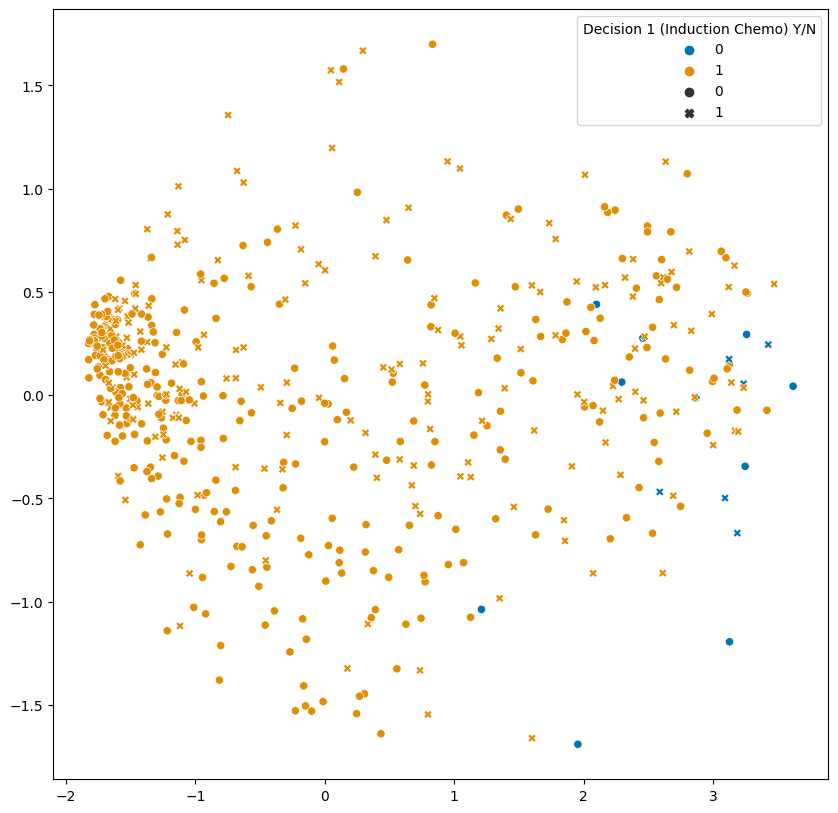

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def plot_embedding(dataset,dmodel,decision=0,ax=None,use_optimal=False):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(10,10))
    embeddings, decisions_optimal, decisions_imitation,inputs = get_embeddings(dataset,dmodel,states=[decision])
    pca = PCA(2)
    coords = pca.fit_transform(embeddings[0])
    marks = data.get_state('decision'+ str(decision+1))
    if use_optimal:
        predicted = (decisions_optimal > .5).ravel().astype(int)
    else:
        predicted = (decisions_imitation > .5).ravel().astype(int)
    size = [400 for i in marks]
    sns.scatterplot(data=coords,
                    x=coords[:,0],
                    y=coords[:,1],
                    style=marks,
                    hue=predicted,
                    ax=ax,
                    palette='colorblind',
                    sizes=size,
                   )
plot_embedding(data,decision_model)

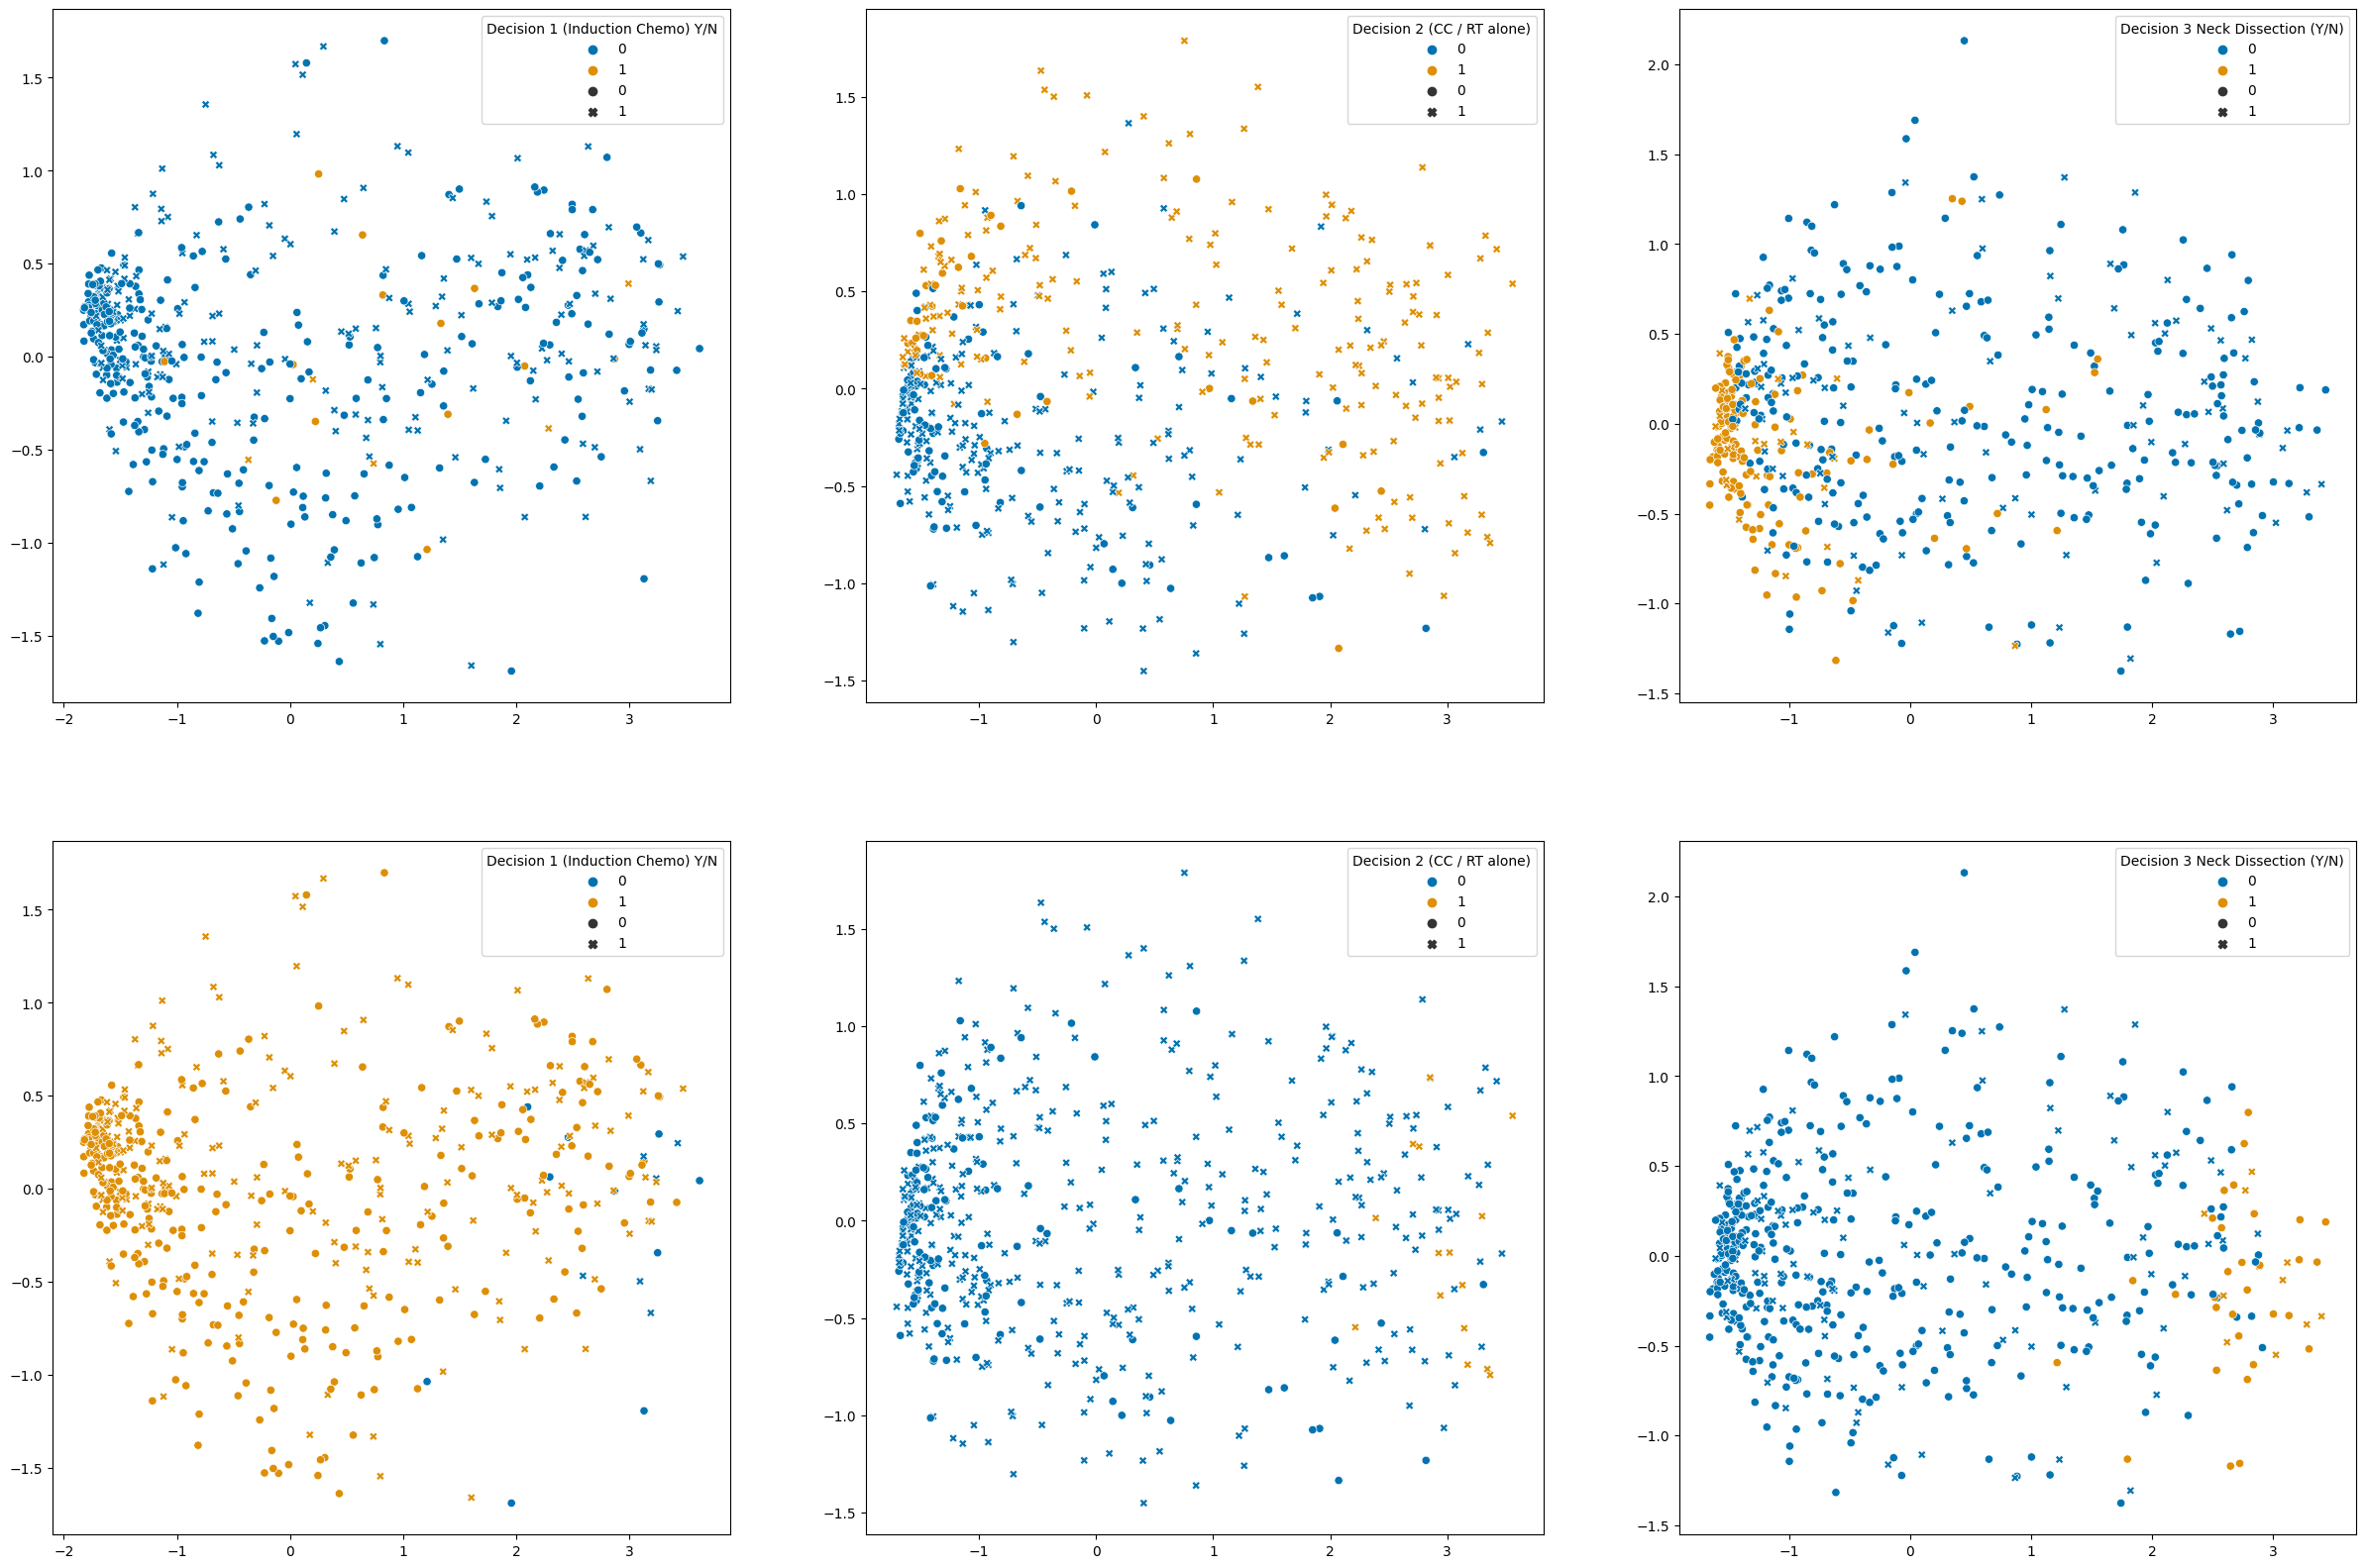

In [20]:
fig,axes = plt.subplots(2,3,figsize=(30,20))
for ii,opt in enumerate([True,False]):
    for i in range(3):
        plot_embedding(data,decision_model,use_optimal=opt,decision=i,ax=axes[ii,i])

In [21]:
def get_default_input(dataset,state=0,ids=None):
    output = get_decision_input(dataset,state=state,ids=ids)
    output = [o.median().to_dict() for o in output]
    return output

get_default_input(data)

[{'1A_contra': 0.0,
  '1A_ipsi': 0.0,
  '1B_contra': 0.0,
  '1B_ipsi': 0.0,
  '2A_contra': 0.0,
  '2A_ipsi': 1.0,
  '2B_contra': 0.0,
  '2B_ipsi': 1.0,
  '3_contra': 0.0,
  '3_ipsi': 0.0,
  '4_contra': 0.0,
  '4_ipsi': 0.0,
  '5A_contra': 0.0,
  '5A_ipsi': 0.0,
  '5B_contra': 0.0,
  '5B_ipsi': 0.0,
  '6_contra': 0.0,
  '6_ipsi': 0.0,
  'AJCC_1': 0.0,
  'AJCC_2': 0.0,
  'AJCC_3': 0.0,
  'AJCC_4': 0.0,
  'African American/Black': 0.0,
  'Aspiration rate Pre-therapy': 0.0,
  'DLT (Y/N)': 0.0,
  'DLT_Grade': 0.0,
  'Hispanic/Latino': 0.0,
  'N-category_0': 0.0,
  'N-category_1': 0.0,
  'N-category_2': 0.0,
  'N-category_3': 0.0,
  'Pathological Grade_0': 0.0,
  'Pathological Grade_1': 0.0,
  'Pathological Grade_2': 0.0,
  'Pathological Grade_3': 1.0,
  'Pathological Grade_4': 0.0,
  'RPLN_contra': 0.0,
  'RPLN_ipsi': 0.0,
  'T-category_1': 0.0,
  'T-category_2': 0.0,
  'T-category_3': 0.0,
  'T-category_4': 0.0,
  'White/Caucasian': 0.0,
  'age': 58.155,
  'bilateral': 0.0,
  'dose_fractio

In [152]:
def format_patient(dataset,input_dict,zero_transitions=True):
    #converts patient input features into data input type
    baselines = dataset.processed_df.median().to_dict()
    #set all basline transition states to 0 so my lazy way of checking for fixed values works
    if zero_transitions:
        to_zero = (Const.primary_disease_states 
            + Const.nodal_disease_states 
            + list(Const.modification_types.values()) 
            + list(Const.cc_types.values()))
        for k in to_zero:
            baselines[k] = 0
            baselines[k+' 2'] = 0
    for k,v in input_dict.items():
        baselines[k] = v
    return baselines

format_patient(data,{'ln_cluster_3': 1,'DLT_Neurological': 1})

{'hpv': 1.0,
 'age': 58.155,
 'packs_per_year': 3.0,
 'smoking_status': 0.5,
 'gender': 1.0,
 'Aspiration rate Pre-therapy': 0.0,
 'total_dose': 70.0,
 'dose_fraction': 2.12,
 'bilateral': 0.0,
 'White/Caucasian': 0.0,
 'Hispanic/Latino': 0.0,
 'African American/Black': 0.0,
 'cc_none': 0,
 'cc_platinum': 0,
 'cc_cetuximab': 0,
 'cc_others': 0,
 'no_dose_adjustment': 0,
 'dose_modified': 0,
 'dose_delayed': 0,
 'dose_cancelled': 0,
 'dose_delayed_&_modified': 0,
 'regiment_modification': 0,
 'unknown': 0,
 'T-category_1': 0.0,
 'T-category_2': 0.0,
 'T-category_3': 0.0,
 'T-category_4': 0.0,
 'N-category_0': 0.0,
 'N-category_1': 0.0,
 'N-category_2': 0.0,
 'N-category_3': 0.0,
 'AJCC_1': 0.0,
 'AJCC_2': 0.0,
 'AJCC_3': 0.0,
 'AJCC_4': 0.0,
 'Pathological Grade_0': 0.0,
 'Pathological Grade_1': 0.0,
 'Pathological Grade_2': 0.0,
 'Pathological Grade_3': 1.0,
 'Pathological Grade_4': 0.0,
 'subsite_BOT': 0.0,
 'subsite_GPS': 0.0,
 'subsite_NOS': 0.0,
 'subsite_Soft palate': 0.0,
 'subsi

In [23]:
def dict_to_model_input(dataset,fdict,state=0,ttype=torch.FloatTensor,concat=True,zero_transition_states=True):
    fdict = format_patient(dataset,fdict)
    order = get_inputkey_order(dataset,state=state)
    inputs = [torch.tensor([fdict[k] for k in ordersubset]).type(ttype).view(1,-1) for ordersubset in order]
    
    #this is assuming the order is baseline, dlt1, dlt2, primary progression, nodal progression, cc type, dose modification
    def zeroinput(position):
        return torch.zeros(inputs[position].shape).type(ttype)
    if zero_transition_states:
        if state == 0 or state == 1:
            inputs[2] = zeroinput(2)
            inputs[5] = zeroinput(5)
        if state < 1:
            inputs[1] = zeroinput(1)
            inputs[3] = zeroinput(3)
            inputs[4] = zeroinput(4)
            inputs[6] =zeroinput(6)
    if concat:
        inputs = torch.cat(inputs,axis=1)
    #currently at this line its baseline, dlt1, dlt2, pd, nd, cc, modifications
    return inputs
# decision_model(*dict_to_model_input(data,data.processed_df.iloc[7].to_dict(),state=0),position=0)
dict_to_model_input(data,data.processed_df.loc[5].to_dict(),state=1,concat=True,zero_transition_states=False)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000, 20.9500,  0.0000,  1.8000,  1.0000,  0.0000,
         38.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000, 72.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000]])

In [147]:
# def input_df(dataset,state=0):
#     df = dataset.processed_df.copy()
#     order = get_inputkey_order(dataset,state=state)
#     inputs = [df[o] for o in order]
#     df = pd.concat(inputs,axis=1)
# input_df(data)

[(536, 56), (536, 8), (536, 8), (536, 3), (536, 3), (536, 4), (536, 7)]


(536, 89)

In [24]:
dict_to_model_input(data,data.processed_df.loc[5].to_dict(),state=1,concat=True,zero_transition_states=True)

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000, 20.9500,  0.0000,  1.8000,  1.0000,  0.0000,
         38.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000, 72.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000]])

In [183]:
def calculateMahalanobis(y=None, data=None, cov=None):
  
    y_mu = y - np.mean(data)
    if not cov:
        cov = np.cov(data.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(y_mu, inv_covmat)
    mahal = np.dot(left, y_mu.T)
    return mahal.diagonal()

def get_neighbors_and_embedding(pdata,dataset,decisionmodel,embedding_df=None,state=2,max_neighbors=10,pcas=None):
    decisionmodel.eval()
    if embedding_df is None:
        embedding_df = get_embedding_df(dataset,decisionmodel)
    embeddings = np.stack(embedding_df['embeddings_state'+str(state)].values)
    
    cat = lambda x: torch.cat(x,axis=1)
    
    inputs = dict_to_model_input(dataset,pdata,state=state,zero_transition_states=False)
    
    
    embedding = decisionmodel.get_embedding(inputs,position=state,use_saved_memory=True)[0].view(1,-1).cpu().detach().numpy()

    mDist = calculateMahalanobis(embedding,embeddings)
    dists = cdist(embedding,embeddings).ravel()
    
    max_neighbors = min(len(dists),max_neighbors)
    min_positions = np.argsort(dists)[:max_neighbors]
    neighbor_ids = dataset.processed_df.index.values[min_positions]
    min_dists = dists[min_positions]
    similarities = 1/(1+min_dists)
    # similarities /= similarities.max() #adjust for rounding errors, self sim should be the max
    if pcas is not None:
        pPca = pcas[state].transform(embedding)[0]
        return neighbor_ids, similarities,embedding[0],pPca, mDist[0]
    return neighbor_ids, similarities, embedding[0], mDist[0]

for state in [0,1,2]:
    print(get_neighbors_and_embedding(test_patient,data,decision_model,state=state)[-1])

248.20581005498644
286.0961180985632
451.644766538527


In [ ]:
271.79988528482323, 323.7389911726347, 490.97099429290034

In [58]:
def test_mahalanobis_distances(dataset=None,decision_model=None,state=1,embedding_df=None):
    if embedding_df is None:
        embedding_df = get_embedding_df(dataset,decision_model)
    embeddings = np.stack(embedding_df['embeddings_state'+str(state)].values)
    dists =calculateMahalanobis(embeddings,embeddings) 
    return np.array(dists)

def get_mdist_outlier_threshold(dataset=None,decision_model=None,embedding_df=None):
    return [m.mean() + 2*m.std() for m in [test_mahalanobis_distances(dataset,decision_model,s,embedding_df) for s in [0,1,2]]]

get_mdist_outlier_threshold(data,decision_model)

[336.01846772321164, 388.3492973565535, 574.5249638759359]

In [83]:
[test_mahalanobis_distances(data,decision_model,s,embedding_df) for s in [0,1,2]]

[array([235.70194863, 243.96248733, 232.79020266, 262.26042924,
        212.83357481, 215.98320591, 346.84754624, 303.17721301,
        266.39063273, 292.78555911, 248.79656612, 336.19810663,
        236.61700385, 271.52358054, 287.55790116, 293.50322404,
        280.89827494, 221.55271864, 268.3879145 , 352.06151019,
        223.15579518, 330.29959793, 300.87135614, 278.69537938,
        311.06950574, 324.28565679, 248.43693734, 235.59846428,
        319.83930342, 277.61230233, 307.63798921, 324.98471312,
        291.00641427, 290.0128361 , 319.20655217, 219.18880701,
        337.25475258, 255.76551428, 314.87897915, 266.45644553,
        293.66794795, 243.75803597, 292.98238088, 281.6875399 ,
        239.8618467 , 228.7858589 , 305.1034489 , 312.99375813,
        340.9716282 , 211.09710577, 316.89002192, 258.5211309 ,
        234.84702051, 378.13764212, 246.2239052 , 301.60780705,
        237.78538224, 232.46021068, 213.57230889, 320.95528958,
        269.86288121, 273.83979883, 289.

In [221]:
def dictify(keys,values):
    return {k:v for k,v in zip(keys,values)}

def get_neighbors_and_embeddings_from_sim(embeddings,dataset,decisionmodel,
                                         embedding_df=None,max_neighbors=100,
                                          pcas=None,
                                          pca_components=2,
                                         ):
    #this is get_embeddings_and_neighbors, but uses the optimal model from get_stuff_For_patient embeddings
    #instead of just kinda not simulation anyhting. adds 1 second on my UIC workstation to the simulation
    if embedding_df is None:
        embedding_df = get_embedding_df(dataset,decisionmodel)
    cat = lambda x: torch.cat(x,axis=1)
    
    embed_arrays = [np.stack(embedding_df['embeddings_state'+str(s)].values) for s in embeddings.keys()]
    if pcas is None:
        pcas = [PCA(pca_components,whiten=True).fit(e) for e in embed_arrays]
    i = 0
    results = {}
    for state, embedding in embeddings.items():
        embedding_array = embed_arrays[i]
        mdist = calculateMahalanobis(embedding.reshape(1,-1),embedding_array)
        
        dists = cdist(embedding,embedding_array).ravel()
        max_neighbors = min(len(dists),max_neighbors)
        min_positions = np.argsort(dists)[:max_neighbors]
        neighbor_ids = dataset.processed_df.index.values[min_positions]
        min_dists = dists[min_positions]
        similarities = 1/(1+min_dists)
        # similarities /= similarities.max() #adjust for rounding errors, self sim should be the max
        pPca = pcas[i].transform(embedding)[0]
        entry = {
            'neighbors': neighbor_ids, 
            'similarities': similarities,
            'embedding': embedding[0],
            'pca': pPca, 
            'mahalanobisDistance': mdist[0]
        }
        results[state] = entry
        i+=1
        
    return results


def get_stuff_for_patient(patient_dict,data,tmodel1,tmodel2,outcomemodel,decisionmodel,state=0,model_type='optimal',**kwargs):
    #this takes a patient dict and returns the results for a full treatment simulation
    #currently if state > 0 it will check if prior transition states are all zero and if not, will input them
    #currently works with categorical, might have to experiment with passing like -1 for fixed "no" with fixed no dlts
    pdata = format_patient(data,patient_dict)
    baseline_inputs = dict_to_model_input(data,pdata,state=0,concat=False) 
    
    
    
    tmodel1.eval()
    tmodel2.eval()
    outcomemodel.eval()
    decisionmodel.eval()
    device = 'cpu'
    if torch.cuda.is_available():
        device='cuda'
    tmodel1.set_device(device)
    tmodel2.set_device(device)
    outcomemodel.set_device(device)
    decisionmodel.set_device(device)
    results = {}
    embeddings = {}
    #do a loop for imitation and a loop for optimal decision making, mod = 3 is imitation
    format_transition = lambda x: x.view(1,-1).to(device)
    #inputs are order baseline, dlt1, dlt2, pd, nd, cc type, dose modifications
    #model output is nx6 -> optimal 1 , 2, 3, imitation 1, 2, 3
    cat = lambda x: torch.cat([xx.to(device) for xx in x],axis=1).to(device)
    
    size_dict = decisionmodel.input_sizes
    
    #baseline, dlt1, dlt2, pd, nd, cc, mod
    input_keys = get_inputkey_order(data)
    def get_attention(xx, position, offset):
        attention = decisionmodel.get_attributions(xx,target=position+offset, position=1)[0].cpu().detach().numpy()
        attention_dict = {
            'step': position,
            'model': 'optimal' if offset == 0 else 'imitation',
            'range': [float(attention.min()),float(attention.max())],
            'baseline': dictify(input_keys[0],attention[0:size_dict['baseline']]),
        }
        pos = size_dict['baseline']
        attention_dict['dlt1'] = dictify(input_keys[1],attention[pos:pos+size_dict['dlt']])
        pos += size_dict['dlt']
        attention_dict['dlt2'] = dictify(input_keys[2], attention[pos:pos+size_dict['dlt']])
        pos += size_dict['dlt']
        attention_dict['pd'] = dictify(input_keys[3], attention[pos:pos+size_dict['pd']])
        pos += size_dict['pd']
        attention_dict['nd'] = dictify(input_keys[4], attention[pos:pos+size_dict['nd']])
        pos += size_dict['nd']
        attention_dict['cc'] = dictify(input_keys[5], attention[pos:pos+size_dict['cc']])
        pos += size_dict['cc']
        attention_dict['modifications'] = dictify(input_keys[6], attention[pos:])
        return attention_dict
        
    memory = get_decision_input(data,state=2)
    memory = cat([df_to_torch(f) for f in memory])
    o1 = decisionmodel(cat(baseline_inputs),position=0)[0]
    
    thresh = lambda x: torch.gt(x,.5).type(torch.FloatTensor)
    
    modifiers = [3] if model_type == 'imitation' else [0]
    if model_type == 'both':
        modifiers = [0,3]
        
    def get_fixed_transitions():
        
        [base, dlt1,_,pd1,nd1,_,mod] =dict_to_model_input(data,pdata,state=1,
                                                          concat=False,zero_transition_states=False)
        [base, _,dlt2,pd2,nd2,cc,_] =dict_to_model_input(data,pdata,state=2,
                                                          concat=False,zero_transition_states=False)
        isfixed = lambda d: not (torch.sum(d) < .00001)
        results = {
            'dlt1': isfixed(dlt1),
            'dlt2': isfixed(dlt2),
            'pd1': isfixed(pd1),
            'pd2': isfixed(pd2),
            'nd1': isfixed(nd2),
            'nd2': isfixed(nd2),
            'cc': isfixed(cc),
            'mod': isfixed(mod)
        }
        return results
    fixed_transitions = get_fixed_transitions()
    print('fixed_decisions',fixed_transitions)
    def run_simulation(modifier,decision1=None,decision2=None,decision3=None):
        #do this to track malahanobis distances?
        is_default = (modifier == modifiers[0] and decision1 is None and decision2 is None and decision3 is None)
        if is_default:
            embeddings[0] = decisionmodel.get_embedding(cat(baseline_inputs),position=0,use_saved_memory=True)
            
        #transition 1 model uses usebaline + decision
        if decision1 is not None:
            d1 = torch.tensor([[decision1]]).type(torch.FloatTensor)
            d1_attention=0
        else:
            d1 = o1[0+modifier].view(1,-1)
            d1_attention = get_attention(cat(baseline_inputs),0,modifier)
        tinput1 = cat([baseline_inputs[0],thresh(d1)])
        
        ytransition = tmodel1(tinput1)
        [ypd1,ynd1,ymod,ydlt1] = ytransition['predictions']

        [ypd1, ynd1, ymod] = [format_transition(i) for i in [ypd1,ynd1,ymod]]
        
        #I try to make this work in the model but it just thinks there's no outcome and softmaxes them all often
        d1_thresh = torch.gt(d1,.5).view(-1,1).to(device)
        ypd1[:,0:2] = ypd1[:,0:2]*d1_thresh
        ynd1[:,0:2] = ynd1[:,0:2]*d1_thresh
        
        oinput2 = dict_to_model_input(data,pdata,state=1,concat=False,zero_transition_states=False)
        #if the input stuff has a value for transition states and state passed is > 0, fix them
        
        #check if I should actually use the transition states
        if state > 0 and fixed_transitions['dlt1']:
            ydlt1 = torch.clone(oinput2[1])
        else:
            oinput2[1] = ydlt1.view(1,-1)
        if state > 0 and fixed_transitions['pd1']:
            ypd1 = torch.clone(oinput2[3])
        else:
            oinput2[3] = ypd1
        if state > 0 and fixed_transitions['nd1']:
            ynd1 = torch.clone(oinput2[4])
        else:
            oinput2[4] = ynd1
        if state > 0 and fixed_transitions['mod']:
            ymod = torch.clone(oinput2[6])
        else:
            oinput2[6] = torch.clone(ymod)
            
            
        if decision2 is not None:
            d2 = torch.tensor([[decision2]]).type(torch.FloatTensor)
            d2_attention=0
        else:
            d2 = decisionmodel(cat(oinput2),position=1)[0,1+modifier].view(1,-1)
            d2_attention = get_attention(cat(oinput2),1,modifier)
        if is_default:
            embeddings[1] = decisionmodel.get_embedding(cat(oinput2),position=1,use_saved_memory=True)
            
        #transition 2 modle uses baseline + pd1 + nd1 + modification + dlt1 + decision 1 + deicsion 2
        tinput2 = [baseline_inputs[0], ypd1, ynd1, ymod,ydlt1, thresh(d1),thresh(d2)]

        tinput2 = cat(tinput2)
        
        ytransition2 = tmodel2(tinput2)
        [ypd2, ynd2, ycc, ydlt2] = ytransition2['predictions']
        [ypd2, ynd2, ycc] = [format_transition(i) for i in [ypd2,ynd2,ycc]]
        
        oinput3 = oinput2[:]
        #check if I should use the transition states again
        if state > 1 and fixed_transitions['dlt2']:
            ydlt2 = torch.clone(oinput3[2])
        else:
            oinput3[2] = ydlt2.view(1,-1)
        if state > 1 and fixed_transitions['pd2']:
            ypd2 = torch.clone(oinput3[3])
        else:
            oinput3[3] = ypd2
        if state > 1 and fixed_transitions['nd2']:
            ynd2 = torch.clone(oinput3[4])
        else:
            oinput3[4] = ynd2
        if state > 1 and fixed_transitions['cc']:
            ycc = torch.clone(oinput3[5])
        else:
            oinput3[5] = torch.clone(ycc)

            
        if decision3 is not None:
            d3 = torch.tensor([[decision3]]).type(torch.FloatTensor)
            d3_attention=0
        else:
            d3 = decisionmodel(cat(oinput3),position = 2)[0,2+modifier].view(1,-1)
            d3_attention = get_attention(cat(oinput3),2,modifier)
        if is_default:
            embeddings[2] =decisionmodel.get_embedding(cat(oinput3),position=2,use_saved_memory=True)
        #outcomes uses baseline + pd2 + nd2 + cc type + dlt2 + decision 1,2,3
        tinput3 = [baseline_inputs[0], ypd2, ynd2, ycc, ydlt2, thresh(d1), thresh(d2), thresh(d3)]
        tinput3 = cat(tinput3)
        outcomes = outcomemodel(tinput3)
        
        entry = {
            'decision1': d1.cpu().detach().numpy()[0][0],
            'decision2': d2.cpu().detach().numpy()[0][0],
            'decision3': d3.cpu().detach().numpy()[0][0],
            'decision1_attention': d1_attention,
            'decision2_attention': d2_attention,
            'decision3_attention': d3_attention,
        }
        def add_to_entry(tmodel_output,names):
            pred = tmodel_output['predictions']
            lower = tmodel_output['5%']
            upper = tmodel_output['95%']
            for suffix,values in zip(['','_5%','_95%'],[pred,lower,upper]):
                for name, v in zip(names,values):
                    v = v.cpu().detach().numpy()
                    if name != 'outcomes':
                        v = v[0]
                    #because of softmax the model will output 33% for pd and nd with no ic when it should be fixed to 0
                    if entry['decision1'] < .5 and ('pd1' in name or 'nd1' in name):
                        v = np.zeros(v.shape)
                    entry[name+suffix] = v
        add_to_entry(ytransition,['pd1','nd1','modifications','dlt1'])
        add_to_entry(ytransition2,['pd2','nd2','cc_type','dlt2'])
        add_to_entry(outcomes,['outcomes'])
        key = 'optimal' if modifier < 1 else 'imitation'
        if decision1 is not None:
            key += '_decision1-'+str(decision1)
        if decision2 is not None:
            key += '_decision2-'+str(decision2)
        if decision3 is not None:
            key += '_decision3-'+str(decision3)
        results[key] = entry

    
    with torch.no_grad():
        for modifier in modifiers:
            for d1_fixed in [None,0,1]:
                for d2_fixed in [None,0,1]:
                    for d3_fixed in [None,0,1]:
                        #we only need to do all fixed outcomes once
                        if d1_fixed is not None and d2_fixed is not None and d3_fixed is not None and modifier != modifiers[0]:
                            continue
                        run_simulation(modifier,d1_fixed,d2_fixed,d3_fixed)
    for k,v in embeddings.items():
        embeddings[k] = v.cpu().detach().numpy()
    embedding_results = get_neighbors_and_embeddings_from_sim(embeddings,data,decisionmodel,**kwargs)
    return {'simulation': results,'embeddings': embedding_results}

def get_test_patient(d,pid=7,clear_transitions=True):
    tp = d.processed_df.loc[pid].to_dict()
    if clear_transitions:
        for v in Const.primary_disease_states + Const.nodal_disease_states:
            tp[v] = 0
            tp[v + ' 2'] = 0
    return tp 

from time import time
t1 = time()
test_patient= get_test_patient(data,7,False)
test_results = get_stuff_for_patient(test_patient,data,
                                     transition_model1,
                                     transition_model2,
                                     outcome_model,
                                     decision_model,
                                     state=1,
                                     max_neighbors=2,
                                     model_type='imitation',
                                    )
t2 = time()
print(t2-t1)
test_results['simulation'].keys()


fixed_decisions {'dlt1': False, 'dlt2': False, 'pd1': False, 'pd2': True, 'nd1': True, 'nd2': True, 'cc': True, 'mod': True}
6.43685245513916


dict_keys(['imitation', 'imitation_decision3-0', 'imitation_decision3-1', 'imitation_decision2-0', 'imitation_decision2-0_decision3-0', 'imitation_decision2-0_decision3-1', 'imitation_decision2-1', 'imitation_decision2-1_decision3-0', 'imitation_decision2-1_decision3-1', 'imitation_decision1-0', 'imitation_decision1-0_decision3-0', 'imitation_decision1-0_decision3-1', 'imitation_decision1-0_decision2-0', 'imitation_decision1-0_decision2-0_decision3-0', 'imitation_decision1-0_decision2-0_decision3-1', 'imitation_decision1-0_decision2-1', 'imitation_decision1-0_decision2-1_decision3-0', 'imitation_decision1-0_decision2-1_decision3-1', 'imitation_decision1-1', 'imitation_decision1-1_decision3-0', 'imitation_decision1-1_decision3-1', 'imitation_decision1-1_decision2-0', 'imitation_decision1-1_decision2-0_decision3-0', 'imitation_decision1-1_decision2-0_decision3-1', 'imitation_decision1-1_decision2-1', 'imitation_decision1-1_decision2-1_decision3-0', 'imitation_decision1-1_decision2-1_deci

In [213]:
responsify(test_results)

NameError: name 'responsify' is not defined

In [140]:
test_patient = get_test_patient(data)

test_patient['no_dose_adjustment'] = 1
test_patient[Const.primary_disease_states[0]] = 1
test_patient[Const.primary_disease_states2[0]] = 1
test_results = get_stuff_for_patient(test_patient,data,
                                     transition_model1,
                                     transition_model2,
                                     outcome_model,
                                     decision_model,
                                     state=2,
                                    )
test_results['simulation']['optimal']['outcomes']

array([0.9605925 , 0.06606537, 0.33399135, 0.9113698 ], dtype=float32)

In [ ]:
def get_default_predictions(dm):
    res  = []
    for state in [0,1,2]:
        mem = dm.memory[state]
        mem = torch.median(mem,dim=0)[0].type(torch.FloatTensor)
        val = dm(mem.reshape(1,-1),position=state)
        res.append(val.cpu().detach().numpy())
    return np.vstack(res)

def get_default_prediction_json(dm):
    vals = get_default_predictions(dm)
    res={}
    for i,model in enumerate(['optimal','imitation']):
        entry = {}
        for state,decision in enumerate(Const.decisions):
            val = vals[state, state + (3*i)]
            entry[decision] = val
        res[model] = entry
    return res
get_default_prediction_json(decision_model)

In [ ]:
import datetime
def np_converter(obj):
    #converts stuff to vanilla python  for json since it gives an error with np.int64 and arrays
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.float32):
        return np.round(float(obj),3)
    elif isinstance(obj, float):
        return round(float(obj),3)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, datetime.datetime) or isinstance(obj, datetime.time):
        return obj.__str__()
    print('np_converter cant encode obj of type', obj,type(obj))
    return obj

import simplejson
keys = ['outcomes','pd1','nd1','decision1','decision1_attention','decision2_attention']
simplejson.dumps(test_results,default=np_converter)

In [ ]:
type(test_results['optimal']['decision1'])

In [ ]:
test_results['optimal'].keys()